<a href="https://colab.research.google.com/github/Gennaro-Farina/Coursera-IBM-ML-course/blob/master/Ml0101ENv3%20-%20Coursera%20IBM%20ML%20Course.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [114]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [115]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2021-05-09 23:50:04--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.02s   

2021-05-09 23:50:04 (1.43 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [116]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [117]:
df.shape

(346, 10)

Index(['Unnamed: 0', 'Unnamed: 0.1', 'loan_status', 'Principal', 'terms',
       'effective_date', 'due_date', 'age', 'education', 'Gender'],
      dtype='object')


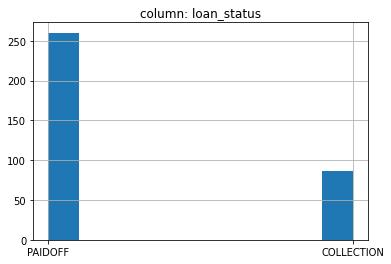

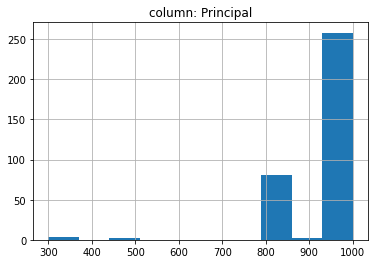

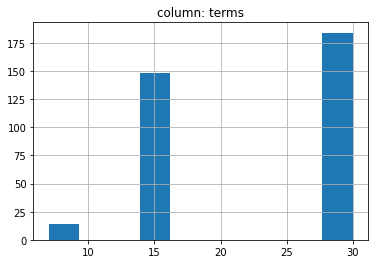

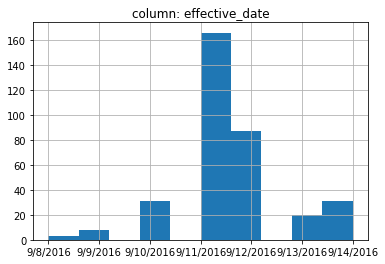

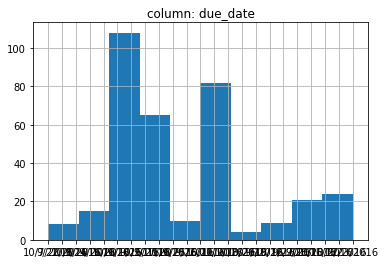

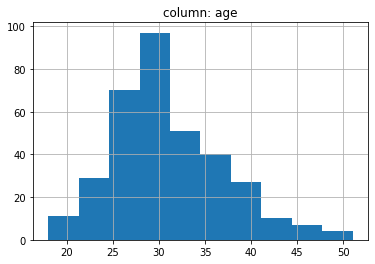

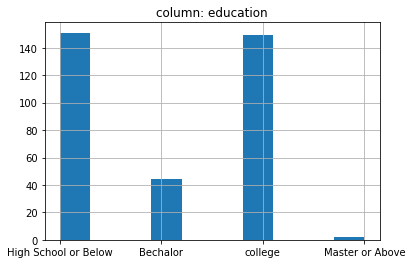

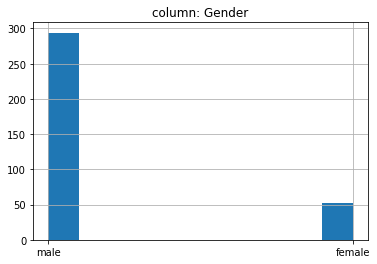

In [118]:
print(df.columns)
for column in df[df.columns[2:]].columns:
    plt.title('column: ' + column)
    df[column].hist()
    plt.show()

### Convert to date time object 

In [119]:
df['due_date']       = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [120]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [121]:
# notice: installing seaborn might takes a few minutes
! conda install -c anaconda seaborn -y
! conda install scikit-learn imbalanced-learn -c conda-forge

! pip install seaborn scikit-learn imbalanced-learn

/bin/bash: conda: command not found
/bin/bash: conda: command not found


In [122]:
#! conda install nb_conda # to grant to select conda environments as core of jupyter notebook

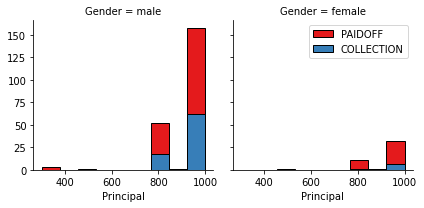

In [123]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

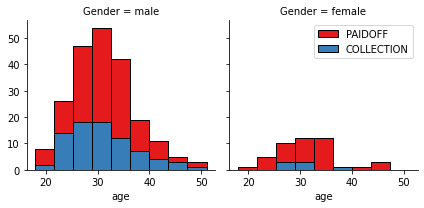

In [124]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

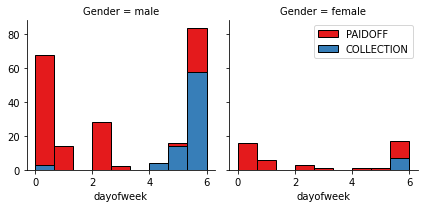

In [125]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [126]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [127]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [128]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [129]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

In [130]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [131]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets define feature sets, X:

In [132]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [133]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data [ + Oversampling of the minority class to address imbalancing -> removed]

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [134]:
from imblearn.over_sampling  import SMOTE
from imblearn.over_sampling  import ADASYN

# transform the dataset
# print(np.sum(y=='PAIDOFF'))
# print(np.sum(y=='COLLECTION'))
# oversample = SMOTE(random_state=42)
# oversample = ADASYN()
# X, y = oversample.fit_resample(X, y)

X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]



array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

In [135]:
# if our set has to be splitted
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.tree            import DecisionTreeClassifier
from sklearn.svm             import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import confusion_matrix

from sklearn                 import tree
from sklearn.decomposition   import PCA

from mpl_toolkits.mplot3d    import Axes3D
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics         import log_loss

# X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

# # shape of data splitted
# print(X_train.shape)
# print(y_train.shape)

# print(X_test.shape)
# print(y_test.shape)

# # transforming Y_train in a numeric field
# y_train_num = [1 if y_i=='PAIDOFF' else 0 for y_i in y_train]
# y_test_num  = [1 if y_i=='PAIDOFF' else 0 for y_i in y_test ]


# # I want to visualize training set with target classes
# pca = PCA(n_components=3)
# X_reduced_PAIDOFF_train = pca.fit(X).transform(X_train)
# X_reduced_PAIDOFF_test  = pca.fit(X).transform(X_test)
# fig = plt.figure(1, figsize=(8, 6))                       
# ax = Axes3D(fig)
# # training data 
# # - will have a more transparency, black edge
# ax.scatter(X_reduced_PAIDOFF_train[:, 0], X_reduced_PAIDOFF_train[:, 1], X_reduced_PAIDOFF_train[:, 2], c=y_train_num, cmap=plt.cm.Set1, edgecolor='k', s=40, alpha=0.4)
# # test data, blue edge
# ax.scatter(X_reduced_PAIDOFF_test[:, 0],  X_reduced_PAIDOFF_test[:, 1],  X_reduced_PAIDOFF_test[:, 2],  c=y_test_num, cmap=plt.cm.Set1, edgecolor='b', s=40)
# ax.set_title("First three PCA directions")
# ax.set_xlabel("1st eigenvector")
# ax.w_xaxis.set_ticklabels([])
# ax.set_ylabel("2nd eigenvector")
# ax.w_yaxis.set_ticklabels([])
# plt.show()

# if we have already splitted our set
X_train = X
y_train = y

# shape of data splitted
print(X_train.shape)
print(y_train.shape)

# transforming Y_train in a numeric field
y_train_num = [1 if y_i=='PAIDOFF' else 0 for y_i in y_train]

(346, 8)
(346,)


# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [136]:
# setting hyperparameters grid
parameters = {
    'n_neighbors': np.linspace(1, int(X_train.shape[0]/2), int(X_train.shape[0]/2) -1).astype(int)
}

# instantiation the generic KNN classifier object
knn_classifier_obj = KNeighborsClassifier()

# grid searching the hyperparameters
clf                = GridSearchCV(knn_classifier_obj, scoring='accuracy', param_grid=parameters)
clf.fit(X_train, y_train_num)

# retrieving best model paramters
print(f'Best estimator: {clf.best_estimator_}. Best estimator type: {type(clf.best_estimator_)}')

# referencing to the best estimator
knn_classifier_obj = clf.best_estimator_

Best estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=47, p=2,
                     weights='uniform'). Best estimator type: <class 'sklearn.neighbors._classification.KNeighborsClassifier'>


# Decision Tree

Best estimator: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='random'). Best estimator type: <class 'sklearn.tree._classes.DecisionTreeClassifier'>


[Text(141.70263157894738, 205.35999999999999, 'X[4] <= 0.225\nentropy = 0.809\nsamples = 346\nvalue = [86, 260]'),
 Text(35.242105263157896, 181.2, 'X[7] <= -0.695\nentropy = 0.149\nsamples = 141\nvalue = [3, 138]'),
 Text(29.368421052631582, 157.04, 'entropy = 0.0\nsamples = 84\nvalue = [0, 84]'),
 Text(41.11578947368422, 157.04, 'X[3] <= 1.639\nentropy = 0.297\nsamples = 57\nvalue = [3, 54]'),
 Text(35.242105263157896, 132.88, 'X[1] <= -0.025\nentropy = 0.342\nsamples = 47\nvalue = [3, 44]'),
 Text(23.494736842105265, 108.72, 'X[0] <= 0.28\nentropy = 0.25\nsamples = 24\nvalue = [1, 23]'),
 Text(17.621052631578948, 84.56, 'X[2] <= 2.381\nentropy = 0.353\nsamples = 15\nvalue = [1, 14]'),
 Text(11.747368421052633, 60.400000000000006, 'X[2] <= 0.647\nentropy = 0.371\nsamples = 14\nvalue = [1, 13]'),
 Text(5.873684210526316, 36.24000000000001, 'entropy = 0.0\nsamples = 9\nvalue = [0, 9]'),
 Text(17.621052631578948, 36.24000000000001, 'X[2] <= 1.864\nentropy = 0.722\nsamples = 5\nvalue = [

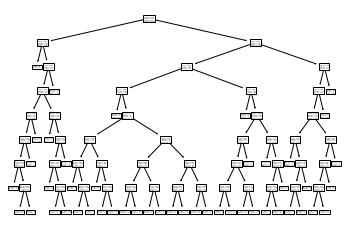

In [137]:
# setting hyperparameters grid
parameters = {
    'criterion'  : ["gini", "entropy"],
    'splitter'   : ["best", "random"],
    'max_depth'  : [X_train.shape[1]],
}

# instantiation the generic decision tree classifier object
dt_classifier_obj = DecisionTreeClassifier(random_state=42)

# grid searching the hyperparameters
clf                = GridSearchCV(dt_classifier_obj, scoring='accuracy', param_grid=parameters)
clf.fit(X_train, y_train_num)

# retrieving best model paramters
print(f'Best estimator: {clf.best_estimator_}. Best estimator type: {type(clf.best_estimator_)}')

# referencing to the best estimator
dt_classifier_obj = clf.best_estimator_
tree.plot_tree(dt_classifier_obj) 

# Support Vector Machine

In [138]:
# setting hyperparameters grid
parameters = {
    'kernel'  : ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree'  : np.linspace(1, 10, 10),
    'gamma'   : ['scale', 'auto']
}

# instantiation the generic SVM classifier object
SVM_classifier_obj = SVC(random_state=42)

# grid searching the hyperparameters
clf                = GridSearchCV(SVM_classifier_obj, scoring='accuracy', param_grid=parameters)
clf.fit(X_train, y_train_num)

# retrieving best model paramters
print(f'Best estimator: {clf.best_estimator_}. Best estimator type: {type(clf.best_estimator_)}')

# referencing to the best estimator
SVM_classifier_obj = clf.best_estimator_


Best estimator: SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2.0, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False). Best estimator type: <class 'sklearn.svm._classes.SVC'>


# Logistic Regression

In [139]:
parameters = {
   'penalty'     : ['l2', 'l1'],
   'tol'         : [1e-03, 1e-04, 1e-05],
   'C'           : [1e-5, 0.001, 0.01, 0.05, 0.5, 1, 2],
   'solver'      : ['liblinear'],
   'class_weight': ['balanced', None]
}



LR_obj = LogisticRegression(random_state=42, max_iter=1000)

# grid searching the hyperparameters
clf                = GridSearchCV(LR_obj, scoring='accuracy', param_grid=parameters)
clf.fit(X_train, y_train_num)


# retrieving best model paramters
print(f'Best estimator: {clf.best_estimator_}. Best estimator type: {type(clf.best_estimator_)}')

# referencing to the best estimator
LR_obj = clf.best_estimator_

Best estimator: LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.001, verbose=0,
                   warm_start=False). Best estimator type: <class 'sklearn.linear_model._logistic.LogisticRegression'>


# Model Evaluation using Test set

In [140]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [141]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-05-09 23:50:20--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-05-09 23:50:21 (611 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [142]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [143]:
print('data size: ', test_df.shape)

# transforng to date into datetime
test_df['due_date']        = pd.to_datetime(test_df['due_date'])
test_df['effective_date']  = pd.to_datetime(test_df['effective_date'])

# retrieve dayofweek
test_df['dayofweek']       = test_df['effective_date'].dt.dayofweek

# transforming dayofweek into boolean weekend flag
test_df['weekend']         = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

print('NaN sum for each column _______________________')
for column in test_df.columns:
    print(f'{column}:', test_df[column].isnull().sum())
print('_______________________________________________')



Feature = test_df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature, pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
print('\n_ Head' + 15*'_' + '\n', Feature.head(), end=2*'\n'+ '_ Description' + 15*'_' + '\n')
print(Feature.describe(), end=3*'\n')

print('NaN sum for each column _______________________')
for column in Feature.columns:
    print(f'{column}:', Feature[column].isnull().sum())
print('_______________________________________________')

# FEATURES SET -> TEST FETURES SET

X_test = Feature
X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)


# TEST TARGET VARIABLE 
# transforming Y_train in a numeric field
y_test     = test_df['loan_status']
y_test_num = [1 if y_i=='PAIDOFF' else 0 for y_i in y_test]



data size:  (54, 10)
NaN sum for each column _______________________
Unnamed: 0: 0
Unnamed: 0.1: 0
loan_status: 0
Principal: 0
terms: 0
effective_date: 0
due_date: 0
age: 0
education: 0
Gender: 0
dayofweek: 0
weekend: 0
_______________________________________________

_ Head_______________
    Principal  terms  age  ...  Bechalor  High School or Below  college
0       1000     30   50  ...         1                     0        0
1        300      7   35  ...         0                     0        0
2       1000     30   43  ...         0                     1        0
3       1000     30   26  ...         0                     0        1
4        800     15   29  ...         1                     0        0

[5 rows x 8 columns]

_ Description_______________
         Principal      terms  ...  High School or Below    college
count    54.000000  54.000000  ...             54.000000  54.000000
mean    914.814815  21.888889  ...              0.388889   0.425926
std     174.190751   8.818

In [144]:
# estimation of predicted classes
yhat = knn_classifier_obj.predict(X_test)

print("->Train<- set Accuracy: ", metrics.accuracy_score(y_train_num, knn_classifier_obj.predict(X_train)))
print(len(yhat), len(y_test_num))

print("Test set Accuracy     : ", metrics.accuracy_score(y_test_num , yhat))
print("Test set Jaccard      : ", metrics.jaccard_score(y_test_num , yhat))
print("Test set F1           : ", metrics.f1_score(y_test_num , yhat))

->Train<- set Accuracy:  0.7543352601156069
54 54
Test set Accuracy     :  0.7777777777777778
Test set Jaccard      :  0.7692307692307693
Test set F1           :  0.8695652173913044


In [145]:
# estimation of predicted classes
yhat = dt_classifier_obj.predict(X_test)

print("->Train<- set Accuracy: ", metrics.accuracy_score(y_train_num, dt_classifier_obj.predict(X_train)))
print("Test set Accuracy     : ", metrics.accuracy_score(y_test_num , yhat))
print("Test set Jaccard      : ", metrics.jaccard_score(y_test_num , yhat))
print("Test set F1           : ", metrics.f1_score(y_test_num , yhat))

->Train<- set Accuracy:  0.7976878612716763
Test set Accuracy     :  0.7407407407407407
Test set Jaccard      :  0.7083333333333334
Test set F1           :  0.8292682926829269


In [146]:
# estimation of predicted classes
yhat = SVM_classifier_obj.predict(X_test)

print("->Train<- set Accuracy: ", metrics.accuracy_score(y_train_num, SVM_classifier_obj.predict(X_train)))
print("Test set Accuracy     : ", metrics.accuracy_score(y_test_num , yhat))
print("Test set Jaccard      : ", metrics.jaccard_score(y_test_num , yhat))
print("Test set F1           : ", metrics.f1_score(y_test_num , yhat))

->Train<- set Accuracy:  0.7514450867052023
Test set Accuracy     :  0.7407407407407407
Test set Jaccard      :  0.7407407407407407
Test set F1           :  0.851063829787234


In [147]:
# estimation of predicted classes
yhat      = LR_obj.predict(X_test)
yhat_prob = LR_obj.predict_proba(X_test)

print("->Train<- set Accuracy: ", metrics.accuracy_score(y_train_num, LR_obj.predict(X_train)))
print("Test set Accuracy     : ", metrics.accuracy_score(y_test_num , yhat))
print("Test set Jaccard      : ", metrics.jaccard_score(y_test_num , yhat))
print("Test set F1           : ", metrics.f1_score(y_test_num , yhat))
print("Test log loss         : ", metrics.log_loss(y_test_num , yhat_prob))

->Train<- set Accuracy:  0.7543352601156069
Test set Accuracy     :  0.7592592592592593
Test set Jaccard      :  0.7547169811320755
Test set F1           :  0.8602150537634409
Test log loss         :  0.48189790404856275


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

1.   Without SMOTE

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.77    | 0.87     | NA      |
| Decision Tree      | 0.71    | 0.83     | NA      |
| SVM                | 0.74    | 0.85     | NA      |
| LogisticRegression | 0.75    | 0.86     | 0.48    |

2.   With SMOTE

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.64    | 0.78     | NA      |
| Decision Tree      | 0.60    | 0.75    | NA      |
| SVM                | 0.55    | 0.71     | NA      |
| LogisticRegression | 0.48   | 0.65     | 0.73    |



<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>